# Time Series Forecasting on Electricity consumption

Dataset: https://www.kaggle.com/aditya230688/jhts-forecasting

We adopt the time-series forecasting by decomposing the time-series into the parts of trend and seasonal. 
We perform the predictions of the trend and seasonal using the different deep-learning models. 
We model the residual by substracting the trend and seasonal from the original data and perform the predictions.
We gather the predictions from the parts of trend, seasonal and residual and form the time-series forecasting.
<br>
<br>
We compare the performance of predictions using the different DL models.

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from deeplearning_model import dense_model, lstm_model, cnn_model, cnnlstm_model

Load the data (https://www.kaggle.com/aditya230688/jhts-forecasting)

In [2]:
df = pd.read_csv('train_6BJx641.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [3]:
# trend.csv, seasonal.csv and residual.csv created from Data exploration.ipynb
trend = pd.read_csv('trend.csv', index_col=0)
seasonal = pd.read_csv('seasonal.csv', index_col=0)
resid = pd.read_csv('residual.csv', index_col=0)
trend.index = pd.to_datetime(trend.index)
seasonal.index = pd.to_datetime(seasonal.index)
resid.index = pd.to_datetime(resid.index)

# Feature engineering

In [4]:
def polytime(data, target='', degree=2):
    '''
    Add the polynomials of features such as x, x**2 and x**3, etc.
    
    Args:
      data (pandas DataFrame): the input DataFrame with the different features
      target (str): The column name of the time-series forecasting.
      degree (int): The degree of polynomial to be added for the features.
    
    Returns:
      pandas DataFrame: The dataframe with the added polynomials of features.
    
    '''
    size = data.shape[0]
    for i in range(1,degree+1):
        x = [j**i for j in range(size)]
        data['x'+str(i)] = x
    # Arrange the "target" column to the last column
    column = list(data.columns)
    column.remove(target)
    column = column + [target]
    data = data[column]
    return data

In [5]:
def lag_generation(data, target='', lag=10, num_lag=100):
    '''
    Add the time-lagged features of the time series with column name, "target"
    
    Args:
      data (pandas DataFrame): the input DataFrame with the different features
      target (str): The column name of the time-series forecasting.
      lag (int): The time unit of lags for the time-lagged features.
      num_lag (int): The number of time-lag features to be added.
      
    Returns:
      pandas DataFrame: The dataframe with the added time-lagged features.
    
    '''
    lag = [i for i in range(lag, num_lag, lag)]
    for i in lag:
        data['lag'+str(i)] = data[target].shift(i).fillna(0.0)
    column = list(data.columns)
    column.remove(target)
    column = column + [target]
    data = data[column]
    return data

In [6]:
def rollingwindow_generation(data, target='', window=10, num_window=5):
    '''
    Add the moving-average features of the time series with column name, 
    "target" with the different window size.
    
    Args:
      data (pandas Dataframe): the input DataFrame with the different features.
      target (str): The column name of the time-series forecasting.
      window (int): The window size of moving average.
      num_window (int): the number of moving-average features to be added, where 
                        the window size is multiple of window.
                        
    Returns:
      pandas DataFrame: The dataframe with the added moving-average features.
    
    '''
    rollingwindow = [i for i in range(2, (num_window+1)*window, window)]
    for i in rollingwindow:
        data['rollingwindow'+str(i)] = data[target].rolling(window=i).mean().fillna(0.0)
    column = list(data.columns)
    column.remove(target)
    column = column + [target]
    data = data[column]
    return data

In [7]:
trend = polytime(trend, target='electricity_consumption', degree=2)
trend = lag_generation(data=trend, target='electricity_consumption', lag=5, num_lag=100)
trend = rollingwindow_generation(data=trend, target='electricity_consumption', num_window=10)
trend['electricity_consumption2'] = trend['electricity_consumption']

In [8]:
seasonal = polytime(seasonal, target='electricity_consumption', degree=3)
seasonal = lag_generation(data=seasonal, target='electricity_consumption', lag=5, num_lag=100)
seasonal['electricity_consumption2'] = seasonal['electricity_consumption']

In [9]:
resid = lag_generation(data=resid, target='electricity_consumption', lag=5, num_lag=100)
resid = rollingwindow_generation(data=resid, target='electricity_consumption', num_window=10)
resid['electricity_consumption2'] = resid['electricity_consumption']

Splitting train and test sets

In [10]:
def train_test_split(data,split=.7):
    '''
    Split the time-series features with train and test date sets.
    
    Args:
      data (pandas Dataframe): the input DataFrame.
      split (float): the split ratio of train and test.
      
    Returns:
      pandas DataFrame: the dataframes of train and test
    
    '''
    train_size = int(len(data)*split)
    train = data[0:train_size]
    test = data[train_size:]
    return train, test

Scaling the features in between 0 and 1

In [11]:
def scalefeature(train, test):
    '''
    Scaling the features of the datasets of train and test
    
    Args:
      train (pandas Dataframe): the input dataframe, train
      test (pandas Dataframe): the input dataframe, test
      
    Returns:
      numpy array: train and test with the scaling features
      dictionary: scale with MinMaxScaler for the different features
    
    '''
    
    column = train.columns

    scale = {}
    temp = pd.DataFrame()
    for col in column:
        scale[col] = MinMaxScaler(feature_range=(0,1))
        temp[col] = scale[col].fit_transform(train[col].values.reshape(-1,1)).reshape(-1)
    train = temp.values

    temp = pd.DataFrame()
    for col in column:
        temp[col] = scale[col].transform(test[col].values.reshape(-1,1)).reshape(-1)
    test = temp.values
    return train, test, scale

In [12]:
trend_train, trend_test = train_test_split(trend, split=.8)
splitsize = trend_train.shape[0]
trend_train, trend_test, trend_scale = scalefeature(trend_train, trend_test)

seasonal_train, seasonal_test = train_test_split(seasonal,split=.8)
seasonal_train, seasonal_test, seasonal_scale = scalefeature(seasonal_train, seasonal_test)

Prepare the features and label for the appropriate input shape of model training

In [13]:
def reshapefeaturelabel(data, input_steps, output_steps):
    '''
    Prepare the features X and label y for the input shape of the deep-learning model
    
    Args:
      data (numpy array): the input features 
      input_steps (int): the number of steps for model training
      output_steps (int): the number of steps for predictions
      
    Returns:
      numpy array: feature X and label y are returned.
      
    '''
    X, y = list(), list()
    for i in range(len(data)):
        endindex = i + input_steps
        out_endindex = endindex + output_steps-1
        if out_endindex > len(data):
            break
        data_x, data_y = data[i:endindex, :-1], data[endindex-1:out_endindex, -1]
        X.append(data_x)
        y.append(data_y)
    return np.array(X), np.array(y)

In [14]:
def reshape_data(train, test):
    '''
    Reshape the numpy array (train and test) for model training.
    
    Args:
      train (numpy array): train data set for reshaping.
      test (numpy array): train data set for reshaping.
      
    Returns:
      numpy array: train and test are returned after reshaping.
    
    '''
    size = train.shape[1]

    trainlist = []
    testlist = []

    for i in range(size):
        trainlist.append(train[:,i].reshape((len(train[:,i]),1)))
        testlist.append(test[:,i].reshape((len(test[:,i]),1)))

    train = np.hstack(tuple(trainlist))
    test = np.hstack(tuple(testlist))
    return train, test

In [15]:
trend_train, trend_test = reshape_data(trend_train, trend_test)
seasonal_train, seasonal_test = reshape_data(seasonal_train, seasonal_test)

# Dense Model 

In [16]:
# input_steps - number of steps for predictions for step
# out_steps - number of steps for predictions
input_steps, output_steps = 10, 48

In [17]:
#Number of epochs
epochs = 50

# batch size
batch_size = 32

Trend part

In [18]:
train_X, train_y = reshapefeaturelabel(trend_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(trend_test, input_steps, output_steps)

num_features = train_X.shape[2]

num_dim = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], num_dim))
test_X = test_X.reshape((test_X.shape[0], num_dim))

model = dense_model(num_dim=num_dim, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
trendpred = {}
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    trendpred[i] = predictvalue
    
trendtrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    trendtrainpred[i] = predictvalue

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                7620      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                5

Seasonal part

In [19]:
train_X, train_y = reshapefeaturelabel(seasonal_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(seasonal_test, input_steps, output_steps)

num_features = train_X.shape[2]

num_dim = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], num_dim))
test_X = test_X.reshape((test_X.shape[0], num_dim))

model = dense_model(num_dim=num_dim, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
seasonalpred = {}
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonalpred[i] = predictvalue
    
seasonaltrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonaltrainpred[i] = predictvalue

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                5620      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 48)               

Residual part

In [20]:
start = (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:splitsize].values

index = df.iloc[start:splitsize].index
residual = pd.DataFrame()
for i in range(output_steps):
    residual['step'+str(i+1)] = truedata - trendtrainpred[i] - seasonaltrainpred[i]
residual.index = index

residual = pd.concat([pd.DataFrame(index=df.index), residual], axis=1).fillna(method='bfill').fillna(method='ffill')
residual = pd.concat([resid, residual], axis=1)

resid_train, resid_test = train_test_split(residual,split=.8)
resid_train, resid_test, resid_scale = scalefeature(resid_train, resid_test)

resid_train, resid_test = reshape_data(resid_train, resid_test)

train_X, train_y = reshapefeaturelabel(resid_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(resid_test, input_steps, output_steps)

start = (input_steps - 1) + (output_steps - 1)
train_y = resid_train[start:,-output_steps:]
test_y = resid_test[start:,-output_steps:]

num_features = train_X.shape[2]

num_dim = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], num_dim))
test_X = test_X.reshape((test_X.shape[0], num_dim))

model = dense_model(num_dim=num_dim, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
residpred = {}
for i in range(output_steps):
    predictvalue = resid_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    residpred[i] = predictvalue

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                16820     
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 48)               

Calculation accuracy of predictions

In [21]:
def calculation_acurracy(rmse, mae, model_name, truedata, pred, output_steps):
    '''
    Calculation of accuracy of predictions using the metrics, root mean squared error and
    mean absolute error
    
    Args:
      rmse (dict): Stores the root mean squared error for the different models.
      mae (dict): Stores the mean absolute error for the different models.
      model_name (str): the model used for prediction.
      truedata (numpy array): test data for out-of-sampling for the predictions with 
                            the n-step output.
      pred (dict): predictions from the model with the n-step output.
      output_steps (int): the number of steps for predictions.
  
    Returns:
      dict: the dictionaries of rmse and mae are returned.
    
    '''
    rmse[model_name] = []
    mae[model_name] = []
    for i in range(output_steps):
        predictvalue = pred[i]
        rmse[model_name].append(mean_squared_error(truedata, predictvalue, squared=False))
        mae[model_name].append(mean_absolute_error(truedata, predictvalue))
    return rmse, mae

In [22]:
pred = {}
for i in range(output_steps):
    pred[i] = trendpred[i] + seasonalpred[i] + residpred[i]
    
    
start = splitsize + (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:].values

rmse = {}
mae = {}
rmse, mae = calculation_acurracy(rmse, mae, "dense", truedata, pred, output_steps)

# LSTM Model

Trend part

In [23]:
train_X, train_y = reshapefeaturelabel(trend_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(trend_test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = lstm_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
trendpred = {}
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    trendpred[i] = predictvalue
    
trendtrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    trendtrainpred[i] = predictvalue

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                1960      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_13 (Dense)             (None, 48)                288       
Total params: 2,303
Trainable params: 2,303
Non-trainable params: 0
_________________________________________________________________
Training time:  112.99891376495361


Seasonal part

In [24]:
train_X, train_y = reshapefeaturelabel(seasonal_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(seasonal_test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = lstm_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
seasonalpred = {}
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonalpred[i] = predictvalue
    
seasonaltrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonaltrainpred[i] = predictvalue

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                1560      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_15 (Dense)             (None, 48)                288       
Total params: 1,903
Trainable params: 1,903
Non-trainable params: 0
_________________________________________________________________
Training time:  123.54985046386719


Residual part

In [25]:
start = (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:splitsize].values

index = df.iloc[start:splitsize].index
residual = pd.DataFrame()
for i in range(output_steps):
    residual['step'+str(i+1)] = truedata - trendtrainpred[i] - seasonaltrainpred[i]
residual.index = index

residual = pd.concat([pd.DataFrame(index=df.index), residual], axis=1).fillna(method='bfill').fillna(method='ffill')
residual = pd.concat([resid, residual], axis=1)

resid_train, resid_test = train_test_split(residual,split=.8)
resid_train, resid_test, resid_scale = scalefeature(resid_train, resid_test)

resid_train, resid_test = reshape_data(resid_train, resid_test)

train_X, train_y = reshapefeaturelabel(resid_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(resid_test, input_steps, output_steps)

start = (input_steps - 1) + (output_steps - 1)
train_y = resid_train[start:,-output_steps:]
test_y = resid_test[start:,-output_steps:]

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = lstm_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
residpred = {}
for i in range(output_steps):
    predictvalue = resid_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    residpred[i] = predictvalue

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                3800      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_17 (Dense)             (None, 48)                288       
Total params: 4,143
Trainable params: 4,143
Non-trainable params: 0
_________________________________________________________________
Training time:  134.80514645576477


Calculation of accuracy of predictions

In [26]:
pred = {}
for i in range(output_steps):
    pred[i] = trendpred[i] + seasonalpred[i] + residpred[i]
    
    
start = splitsize + (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:].values

rmse, mae = calculation_acurracy(rmse, mae, "lstm", truedata, pred, output_steps)

# CNN Model

Trend part

In [27]:
train_X, train_y = reshapefeaturelabel(trend_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(trend_test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = cnn_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
trendpred = {}
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    trendpred[i] = predictvalue
    
trendtrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    trendtrainpred[i] = predictvalue

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            2496      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                3210      
_________________________________________________________________
dense_19 (Dense)             (None, 48)                528       
Total params: 6,234
Trainable params: 6,234
Non-trainable params: 0
_________________________________________________________________
Training time:  46.223525524139404


Seasonal part

In [28]:
train_X, train_y = reshapefeaturelabel(seasonal_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(seasonal_test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = cnn_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
seasonalpred = {}
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonalpred[i] = predictvalue
    
seasonaltrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonaltrainpred[i] = predictvalue

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 64)            1856      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                3210      
_________________________________________________________________
dense_21 (Dense)             (None, 48)                528       
Total params: 5,594
Trainable params: 5,594
Non-trainable params: 0
_________________________________________________________________
Training time:  42.14081931114197


Residual part

In [29]:
start = (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:splitsize].values

index = df.iloc[start:splitsize].index
residual = pd.DataFrame()
for i in range(output_steps):
    residual['step'+str(i+1)] = truedata - trendtrainpred[i] - seasonaltrainpred[i]
residual.index = index

residual = pd.concat([pd.DataFrame(index=df.index), residual], axis=1).fillna(method='bfill').fillna(method='ffill')
residual = pd.concat([resid, residual], axis=1)

resid_train, resid_test = train_test_split(residual,split=.8)
resid_train, resid_test, resid_scale = scalefeature(resid_train, resid_test)

resid_train, resid_test = reshape_data(resid_train, resid_test)

train_X, train_y = reshapefeaturelabel(resid_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(resid_test, input_steps, output_steps)

start = (input_steps - 1) + (output_steps - 1)
train_y = resid_train[start:,-output_steps:]
test_y = resid_test[start:,-output_steps:]

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], num_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], num_features))

model = cnn_model(input_steps=input_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
residpred = {}
for i in range(output_steps):
    predictvalue = resid_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    residpred[i] = predictvalue

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 10, 64)            5440      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                3210      
_________________________________________________________________
dense_23 (Dense)             (None, 48)                528       
Total params: 9,178
Trainable params: 9,178
Non-trainable params: 0
_________________________________________________________________
Training time:  49.63211679458618


Calculation of accuracy of predictions

In [30]:
pred = {}
for i in range(output_steps):
    pred[i] = trendpred[i] + seasonalpred[i] + residpred[i]
    
    
start = splitsize + (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:].values

rmse, mae = calculation_acurracy(rmse, mae, "cnn", truedata, pred, output_steps)

# CNN-LSTM Model

In [31]:
input_steps = 25
num_seq = 5
num_steps = 5

Trend part

In [32]:
train_X, train_y = reshapefeaturelabel(trend_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(trend_test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], num_seq, num_steps, num_features))
test_X = test_X.reshape((test_X.shape[0], num_seq, num_steps, num_features))

model = cnnlstm_model(num_steps=num_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
trendpred = {}
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    trendpred[i] = predictvalue
    
trendtrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = trend_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = trend_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    trendtrainpred[i] = predictvalue

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 5, 64)       2496      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                11920     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 48)                1008      
Total params: 15,424
Trainable params: 15,424
Non-trainable params: 0
__________________________________________________

Seasonal part

In [33]:
train_X, train_y = reshapefeaturelabel(seasonal_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(seasonal_test, input_steps, output_steps)

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], num_seq, num_steps, num_features))
test_X = test_X.reshape((test_X.shape[0], num_seq, num_steps, num_features))

model = cnnlstm_model(num_steps=num_steps, num_features=num_features, output_steps=output_steps)

start = time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
end = time()
print("Training time: ",end - start)

testPredict = model.predict(test_X)
seasonalpred = {}
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(test_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonalpred[i] = predictvalue
    
seasonaltrainpred = {}
trainPredict = model.predict(train_X)
for i in range(output_steps):
    truevalue = seasonal_scale['electricity_consumption'].inverse_transform(train_y[:,i].reshape(-1,1)).reshape(-1)
    predictvalue = seasonal_scale['electricity_consumption'].inverse_transform(trainPredict[:,i].reshape(-1,1)).reshape(-1)
    seasonaltrainpred[i] = predictvalue

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 5, 64)       1856      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                11920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 48)                1008      
Total params: 14,784
Trainable params: 14,784
Non-trainable params: 0
_________________________________________________

Residual part

In [34]:
start = (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:splitsize].values

index = df.iloc[start:splitsize].index
residual = pd.DataFrame()
for i in range(output_steps):
    residual['step'+str(i+1)] = truedata - trendtrainpred[i] - seasonaltrainpred[i]
residual.index = index

residual = pd.concat([pd.DataFrame(index=df.index), residual], axis=1).fillna(method='bfill').fillna(method='ffill')
residual = pd.concat([resid, residual], axis=1)

resid_train, resid_test = train_test_split(residual,split=.8)
resid_train, resid_test, resid_scale = scalefeature(resid_train, resid_test)

resid_train, resid_test = reshape_data(resid_train, resid_test)

train_X, train_y = reshapefeaturelabel(resid_train, input_steps, output_steps)
test_X, test_y = reshapefeaturelabel(resid_test, input_steps, output_steps)

start = (input_steps - 1) + (output_steps - 1)
train_y = resid_train[start:,-output_steps:]
test_y = resid_test[start:,-output_steps:]

num_features = train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], num_seq, num_steps, num_features))
test_X = test_X.reshape((test_X.shape[0], num_seq, num_steps, num_features))

start = time()
model = cnnlstm_model(num_steps=num_steps, num_features=num_features, output_steps=output_steps)
end = time()
print("Training time: ",end - start)

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)

testPredict = model.predict(test_X)
residpred = {}
for i in range(output_steps):
    predictvalue = resid_scale['electricity_consumption'].inverse_transform(testPredict[:,i].reshape(-1,1)).reshape(-1)
    residpred[i] = predictvalue

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 5, 64)       5440      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                11920     
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 48)                1008      
Total params: 18,368
Trainable params: 18,368
Non-trainable params: 0
_________________________________________________

Calculation of accuracy of predictions

In [35]:
pred = {}
for i in range(output_steps):
    pred[i] = trendpred[i] + seasonalpred[i] + residpred[i]
    
start = splitsize + (input_steps - 1) + (output_steps - 1)
truedata = df['electricity_consumption'].iloc[start:].values

rmse, mae = calculation_acurracy(rmse, mae, "cnn-lstm", truedata, pred, output_steps)

# Comparsion of predictions of different models

(1.0, 48.0)

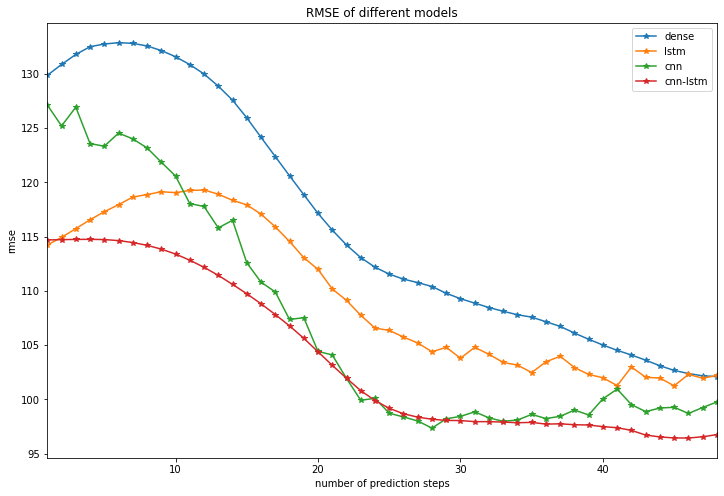

In [36]:
temp = pd.DataFrame(rmse)
index = [i for i in range(1, output_steps+1)]
temp.index = index

temp.plot(marker="*", title='RMSE of different models', figsize=(12,8))
plt.xlabel('number of prediction steps')
plt.ylabel('rmse')
plt.xlim([1,output_steps])

(1.0, 48.0)

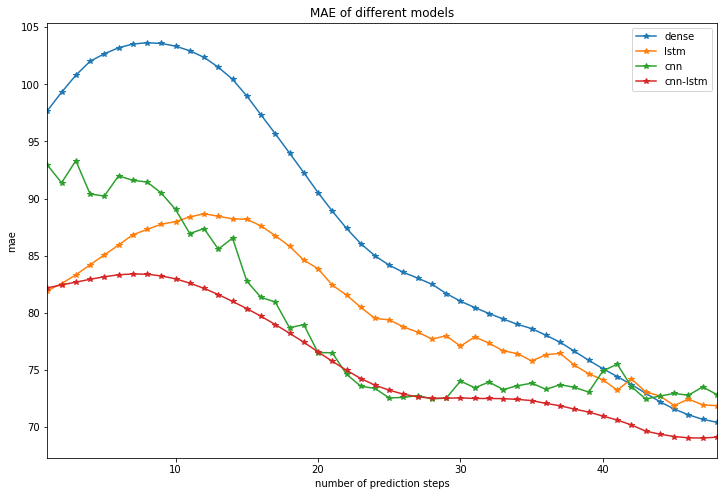

In [37]:
temp = pd.DataFrame(mae)
index = [i for i in range(1, output_steps+1)]
temp.index = index

temp.plot(marker="*", title='MAE of different models', figsize=(12,8))
plt.xlabel('number of prediction steps')
plt.ylabel('mae')
plt.xlim([1,output_steps])

# Summary

We compare the predictions using the different deep-learning models. They exhibit the predictions with a higher accuracy in a longer term. 